In [4]:
from IPython.display import Image

# [Sequence-to-Sequence Modeling with Neural Networks](https://sites.google.com/view/seq2seq-icml17)

Sun, 8/5/2017

[Oriol Vinyals](https://2017.icml.cc/Conferences/2017/Schedule?showSpeaker=6462-8) (Google DeepMind)

Navdeep Jaitly (NVIDIA)

*Seq2Seq learning was introduced in 2014, and has since been extensively studied and extended to a large variety of domains. Seq2Seq yields state-of-the-art performance on several applications such as __machine translation__, image captioning, __speech generation__, or summarization.*

__Code__ to get started and understand the basics is [here](https://github.com/keveman/tensorflow-tutorial/blob/master/PTB%20Word%20Language%20Modeling.ipynb).

__Slides__ are on Google drive, but [here](../slides/Seq2SeqTutorial.pdf) is a PDF copy.

## Overview

- Classical models for sequence prediction
  - Classically handled as a structured prediction task:
    - Built on conditionally independent assumptions
    - Others (DAGGER) based on supervisory signals and auxiliary information
    
- Two key ingredients:
  1. Neural embeddings
    * Map unstructured data into vectors
  2. Recurrent language models
  
- n-gram models
  - Very sparse
  - Based on independent assumptions
  - Huge size, computational complexity (vocab_size ^ n)
  
- A key insight:
  - Vectorizing context (as a product of embeddings)
  - i.e., RNNs
    - Recursively build the contextual embedding state, add softmax layer at the end to predict next term
    
- seq2seq
  - Autoregressive (so, lagged) language model where $x$ predicts $y$, which predicts $z$, etc.
  - Beam search 
    - Given some token (partial hypothesis), expand to `len(partial_hypothesis) + 1` (expanded hypotheses), sort by probability and prune to beam size

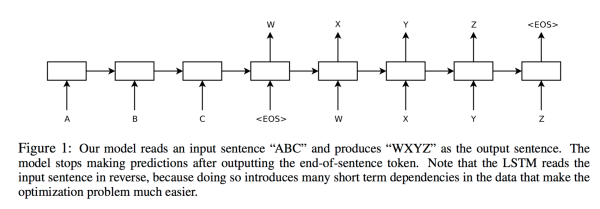

In [5]:
Image(filename='.img/seq2seq-fig-1.png')

### Some tricks of the trade
Google's approach is to try to overfit their network architectures as they develop them just to see if they have the capacity to overfit&mdash;i.e., converge&mdash;and then they start go back and regularize, etc., to fit on whole training set.

1. Long sequences?
  - Use the concept of ["attention" *(or "thought" vector)*](#attention-based-embedding)
  - Bigger state
  
2. Can't overfit?
  - Bigger hidden state
  - Deep LSTM + skip connections
  
3. Overfit? 
  - Dropout + ensembles
  
4. Tuning
  - Decrease learning rate
  - Initialization of parameters is critical (in seq2seq they used `uniform(-0.05, 0.05)`)
  - Clip gradients to `[-5., 5.]`

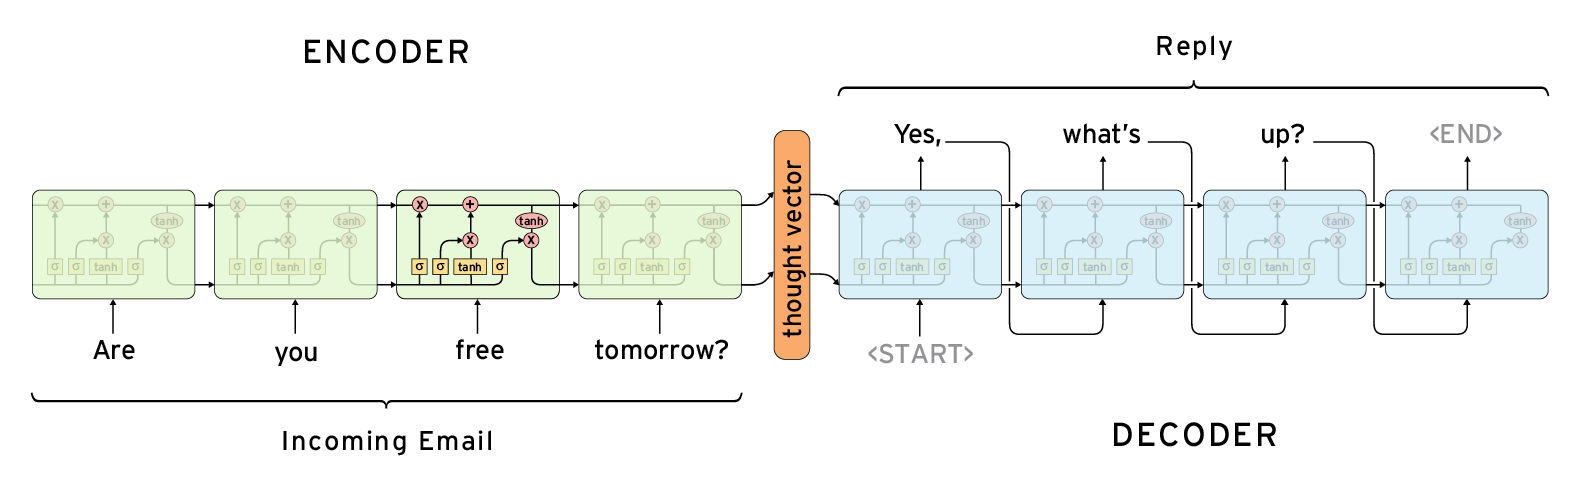

In [6]:
Image(filename='.img/seq2seq2.png')

### Meta learning
- Given a small dataset of training examples
  - Treat the examples within the set as a sequence
  - Feed $x_{i}, y_{i}$ and $x_{j}, y_{j}$ (in differing classes), and then feed $x_{k}$; model predicts $y_{k}$.
    - Like an online classifier

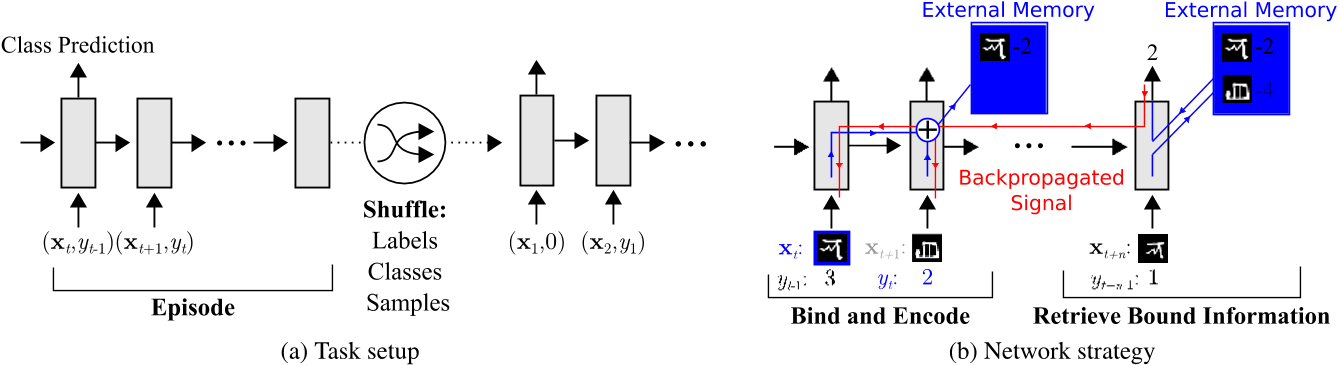

In [7]:
Image(filename='.img/2-Figure1-1.png')

Papers to read:
1. [Joint Language and Translation Modeling with Recurrent Neural Networks](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.482.6877&rep=rep1&type=pdf)
2. [Recurrent Continuous Translation Models](http://www.aclweb.org/anthology/D13-1176)
3. [Learning Phrase Representations Using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/pdf/1406.1078.pdf)
4. [Sequence to Sequence Learning with Neural Networks](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)

#### - The issue with long inputs
  - Same embedding informs the entire output
  - Needs to capture all the information about the input regardless of its length
  - __Is there a better way to pass the information from the encoder to the decoder?__

<a id='attention-based-embedding'></a>
## Attention-based embedding
- Splits apart the encoder and the decoder into two
  - $encoder \rightarrow f(input, h1) \rightarrow decoder \rightarrow f(input, h2) \rightarrow decoder \rightarrow f(input, h3)$
- Result: __Context vector__
- Linear blending of embedding RNN states is a natural choice
- How to produce the coefficients (attention vector) for blending?
  - Content based coefficients based on query state $h_{i}$ and embedding RNN states $e_{1}e_{2}e_{3}e_{4}$

### - Dot-product attention
- Inputs: "I am a cat"
- Input RNN states: $e_{1}e_{2}e_{3}e_{4}$
- Decoder RNN state at step $i$ (query): $h_{i}$
- Compute scalars $h_{i}^{T}e_{1}h_{i}^{T}e_{2}h_{i}^{T}e_{3}h_{i}^{T}e_{4}$ representing similarity between encoder and query

### - Other strategies for attention
- Tensored attention
- Multiple heads
- Pyramidal encoders
- Hierarchical attention
- Hard attention


## Applications
### - Sentence to Constituency Parse Tree
  1. Read a sentence
  2. Flatten the tree into a sequence (adding (,))
  3. "Translate" from sentence to parse tree:

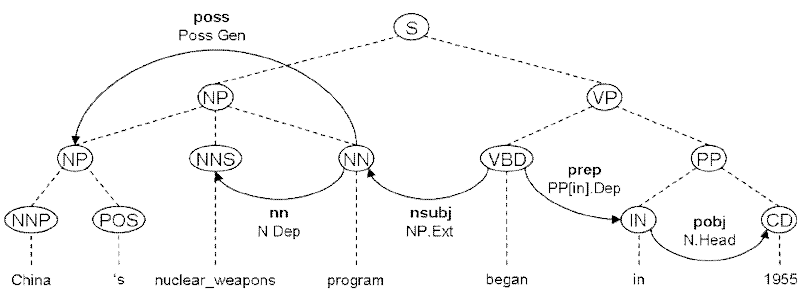

In [8]:
Image(filename='.img/parse-tree.png')

### - Pointer networks
  - Rather than using softmax layer for classification task (where target dictionary size would change), hijack the attention vector to determine where it's pointing.


## Loss functions
1. Cross entropy (negative log likelihood)
  - Actually creates a mismatch between what happens at training and inference
  
  $$\log p(\mathbf{y}|\mathbf{x}) = \sum_{i=1}^{N}\log p(y_{i}|y_{<i}, \mathbf{x})$$

2. [Scheduled sampling](https://papers.nips.cc/paper/5956-scheduled-sampling-for-sequence-prediction-with-recurrent-neural-networks.pdf)

  $$P(y_{t}|h_{t}) \textrm{ with } h_{t} = f(h_{t-1}, \hat{y}_{t-1}; \theta)$$

3. Expected reward (-loss)
  - Given a dataset of input output pairs, $\mathcal{D} \equiv \{(\mathbf{x}^{(i)}, \mathbf{y}^{(i)*})\}_{i=1}^{N}$
  - Learn a conditional distribution $p_{\theta}(\mathbf{x} | \mathbf{y})$ that minimizes expected loss:
  
  $$\mathcal{L}_{\textrm{RL}}(\theta) = \sum_{(\mathbf{x},\mathbf{y}^{*}) \in \mathcal{D}} - \sum_{\mathbf{y} \in \mathcal{Y}} p_{\theta}(\mathbf{y} | x) r(\mathbf{y},\mathbf{y}^*)$$
  
  - __This is difficult/impossible to train from scratch!__

4. Augmented loss (Reward Augmented Maximum Likelihood)
  - Finding the right output sequence is like finding a needle in a haystack. It is risky to shoot only for the true target. What if we expand the targets to make learning easier? E.g., by adding, deleting random words.
  
5. Margin loss
  - Do a beam search until you reach a point where the inference deviates from the correct transcript
  - E.g., beam size = 3 if it falls off at 4
  
  
## Advanced topics
Some more esoteric uses of sequential models...

### - Autoregressive Generative Models
- PixelRNN
  - Fully visible
  - Similar to language models with RNNs
  - Model pixels with softmax
    - Each pixel is a product of log probabilities of previously infered pixel values (discretized 0 - 255)

### - Wavenets
- Similar to pixelRNN, but for waveforms
- Infer 1ms at a time

### - Video Pixel Network
- Predict future frames of a video


## Online seq2seq
### - Practical limitations of online seq2seq
  - Have to wait for all of the input to arrive
  - Yet, attention vector reveals a lot of globally <something...>

- Has to solve following problem:
  - Has enough information arrived to make next inference?
  
### - Sequence transducer


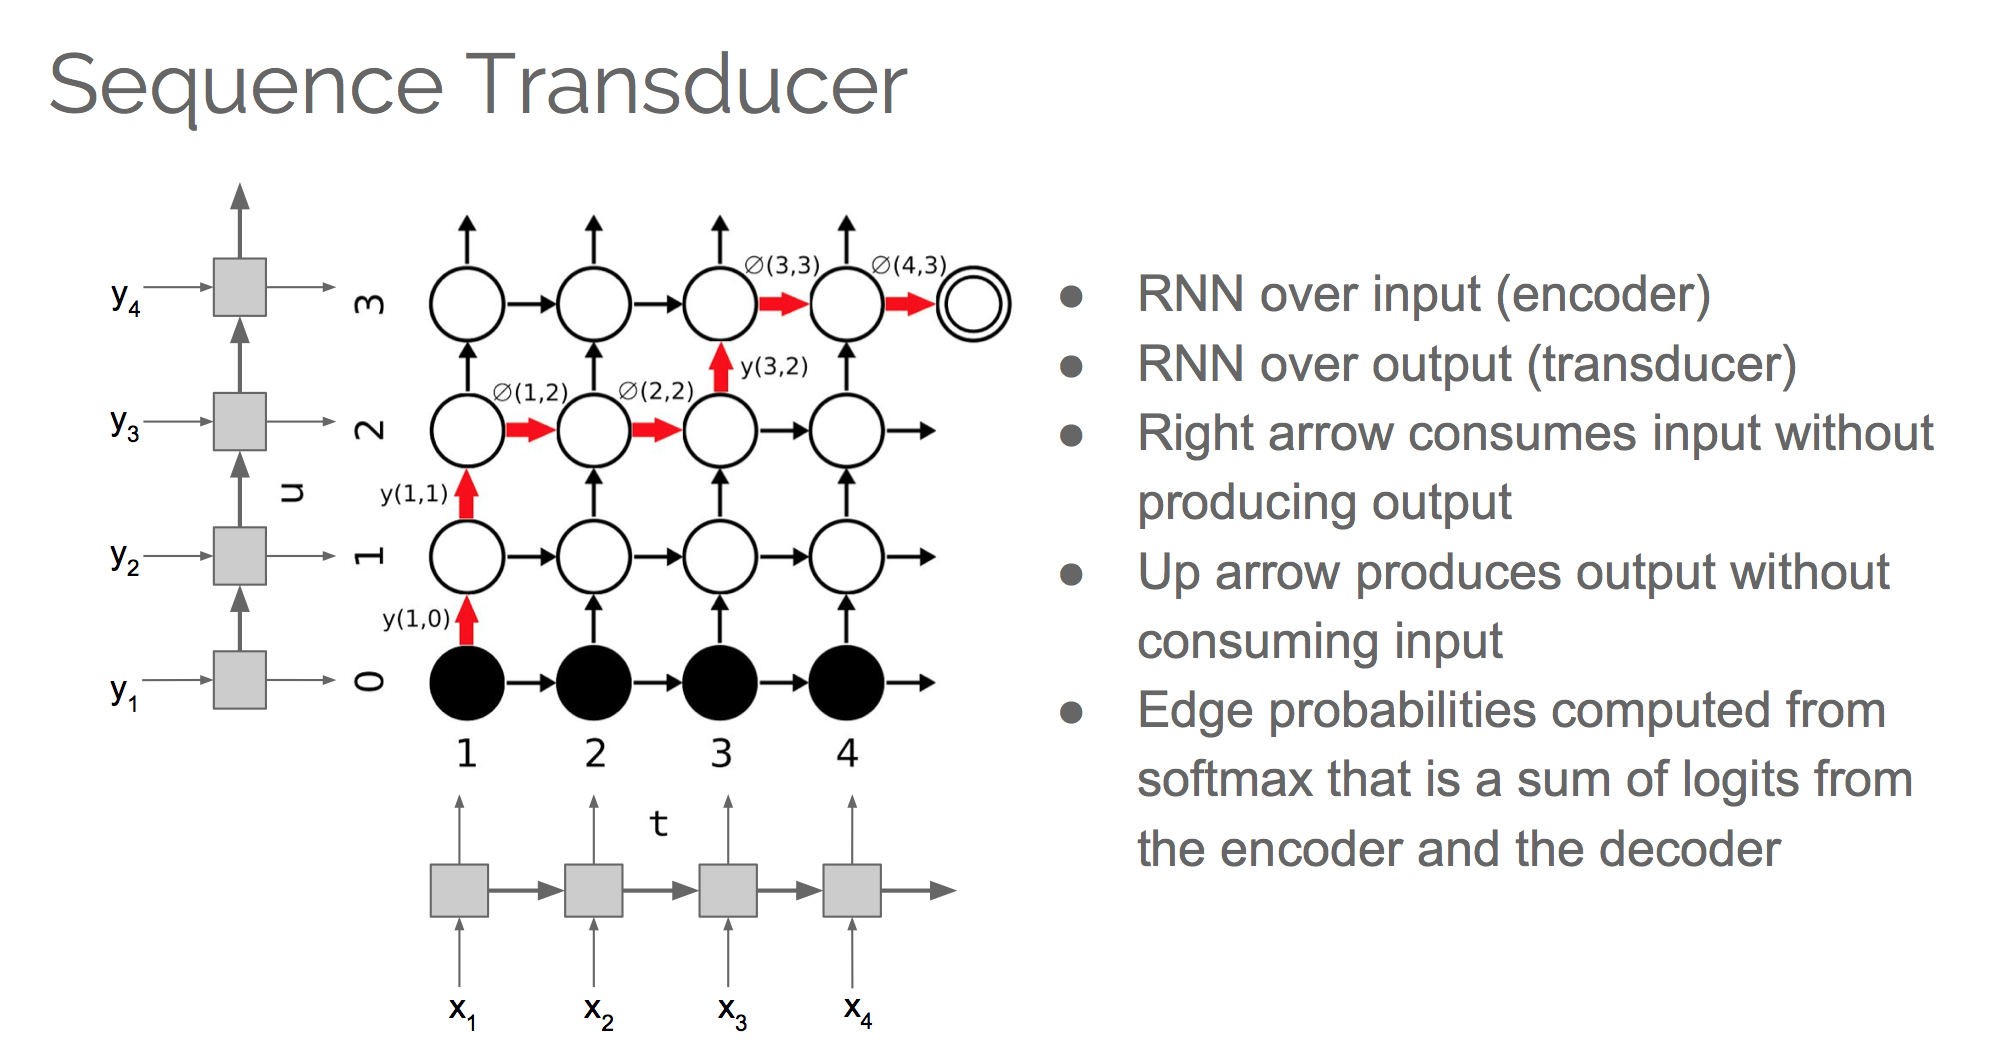

In [9]:
Image(filename='.img/st1.png')

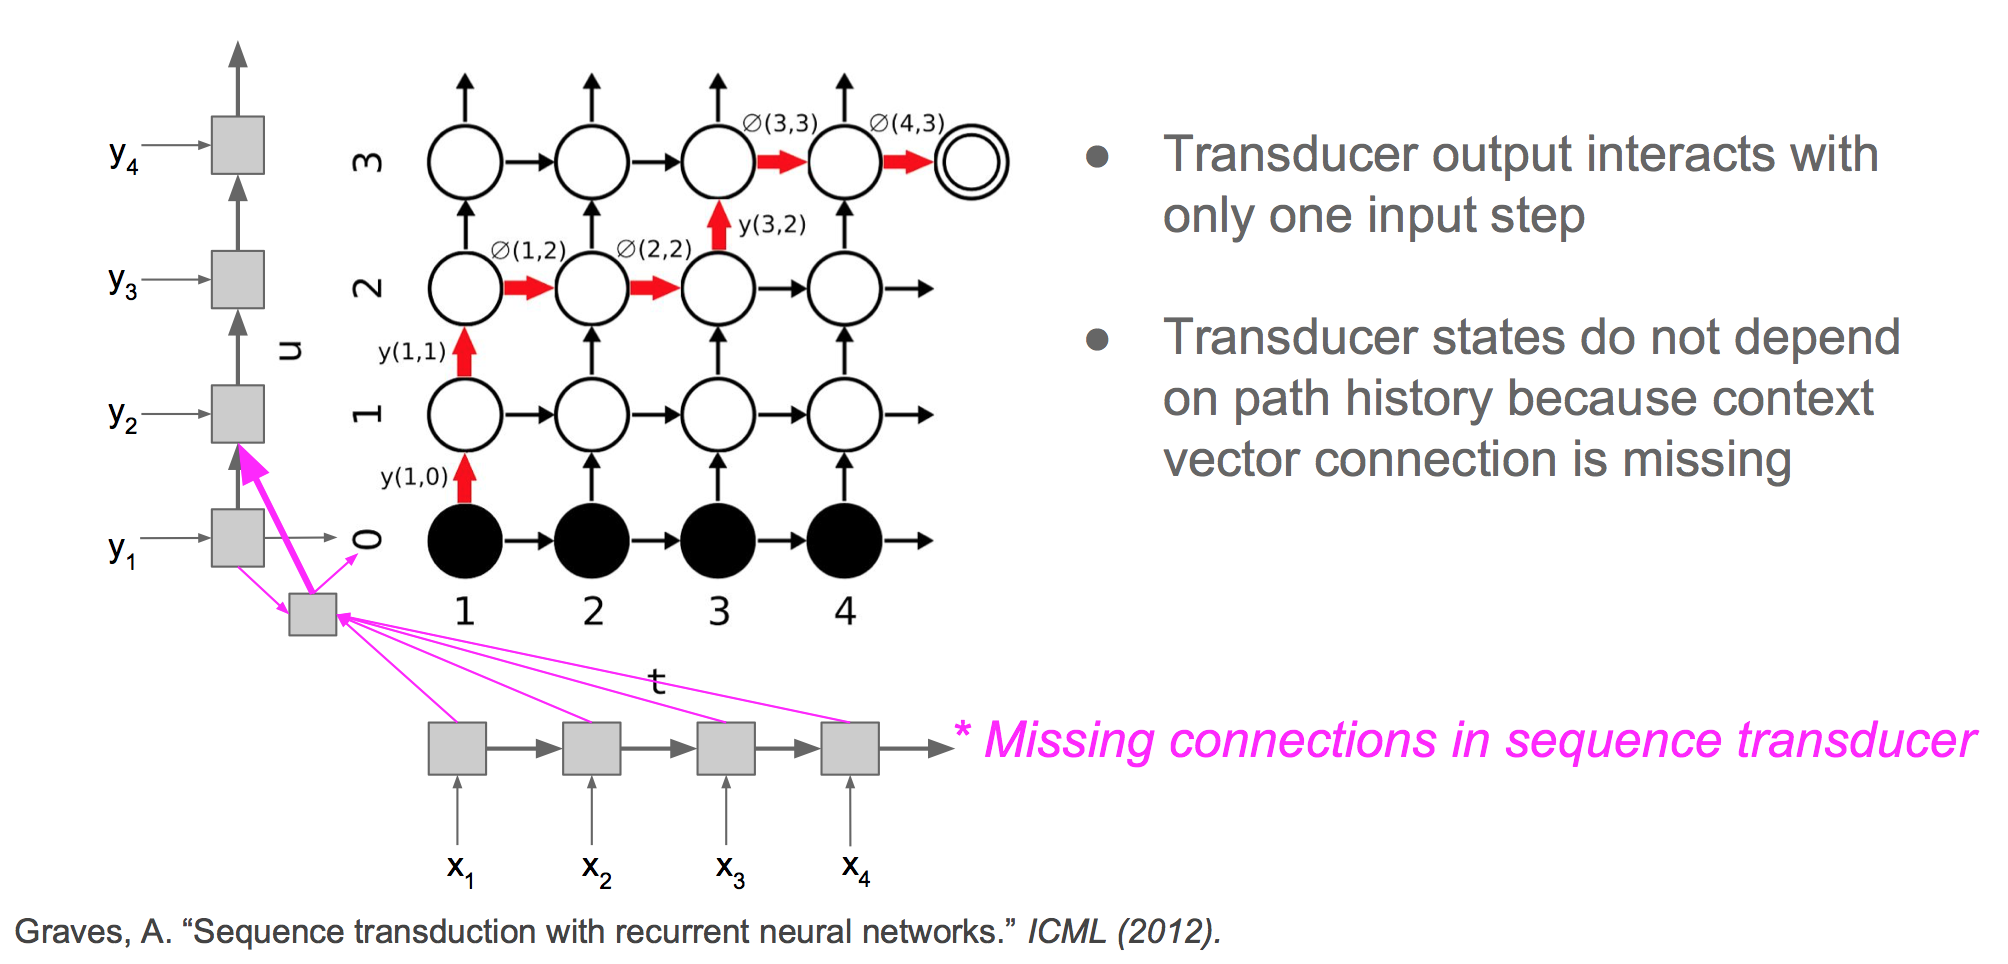

In [10]:
Image(filename='.img/st2.png')

## State Farm application thoughts
Obviously the most relevant project for this work would be any chatbot or text work going on. Anya comes to mind.

- Anya skill default response can be generative, still allowing for REST/JSON logic trees
- Still store states in KV
- Still use median average similarity for skill identification & delegation to skills where necessary

## Code snippets

Here's a relatively simple implementation of seq2seq for generating inferential responses to a user's input:

In [11]:
from __future__ import print_function, division, unicode_literals
import tensorflow as tf
import numpy as np

# for consistency's sake...
print("Tensorflow version: %s" % tf.__version__)
print("Numpy version: %s" % np.__version__)

Tensorflow version: 1.1.0
Numpy version: 1.12.1


### LSTM cell

Build the basic LSTM cell as a sklearn `BaseEstimator`. Long short term memory 
(LSTM) cells  produces output and next state using the following equation: 

$$h_{t}, C_{t} = lstm(x_{t}, h_{t-1}, C_{t-1})$$
        
LSTMs attempt to address the problem of "state" in neural networks. For
instance, humans do not learn or comprehend statelessly. Your understanding
of a situation is a product of what happened just before it (and before
that, ad infinitum). RNNs solve this problem; they are neural networks
with loops in them, allowing information to persist. Although RNNs are
capable of using previous context to better estimate the next state,
they run into an issue when the context is far back. For instance:

    "The clouds are in the <sky>"

An RNN would have no issue inferring "sky," but what if the context is
much further back in the sentence?

    "Since I grew up in France, my parents made sure I knew 
    how to speak fluent <French>"

An RNN might have more trouble with context so far back in the sentence.
LSTMs seek to solve this issue [[1]](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). 
This problem was explored by Bengio, et al. (1994) [[3]](http://www-dsi.ing.unifi.it/~paolo/ps/tnn-94-gradient.pdf). 
LSTMs are explicitly designed to avoid the long-term dependency problem.
Instead of having a single neural network layer, LSTMs contain four, 
interacting in a very special way:


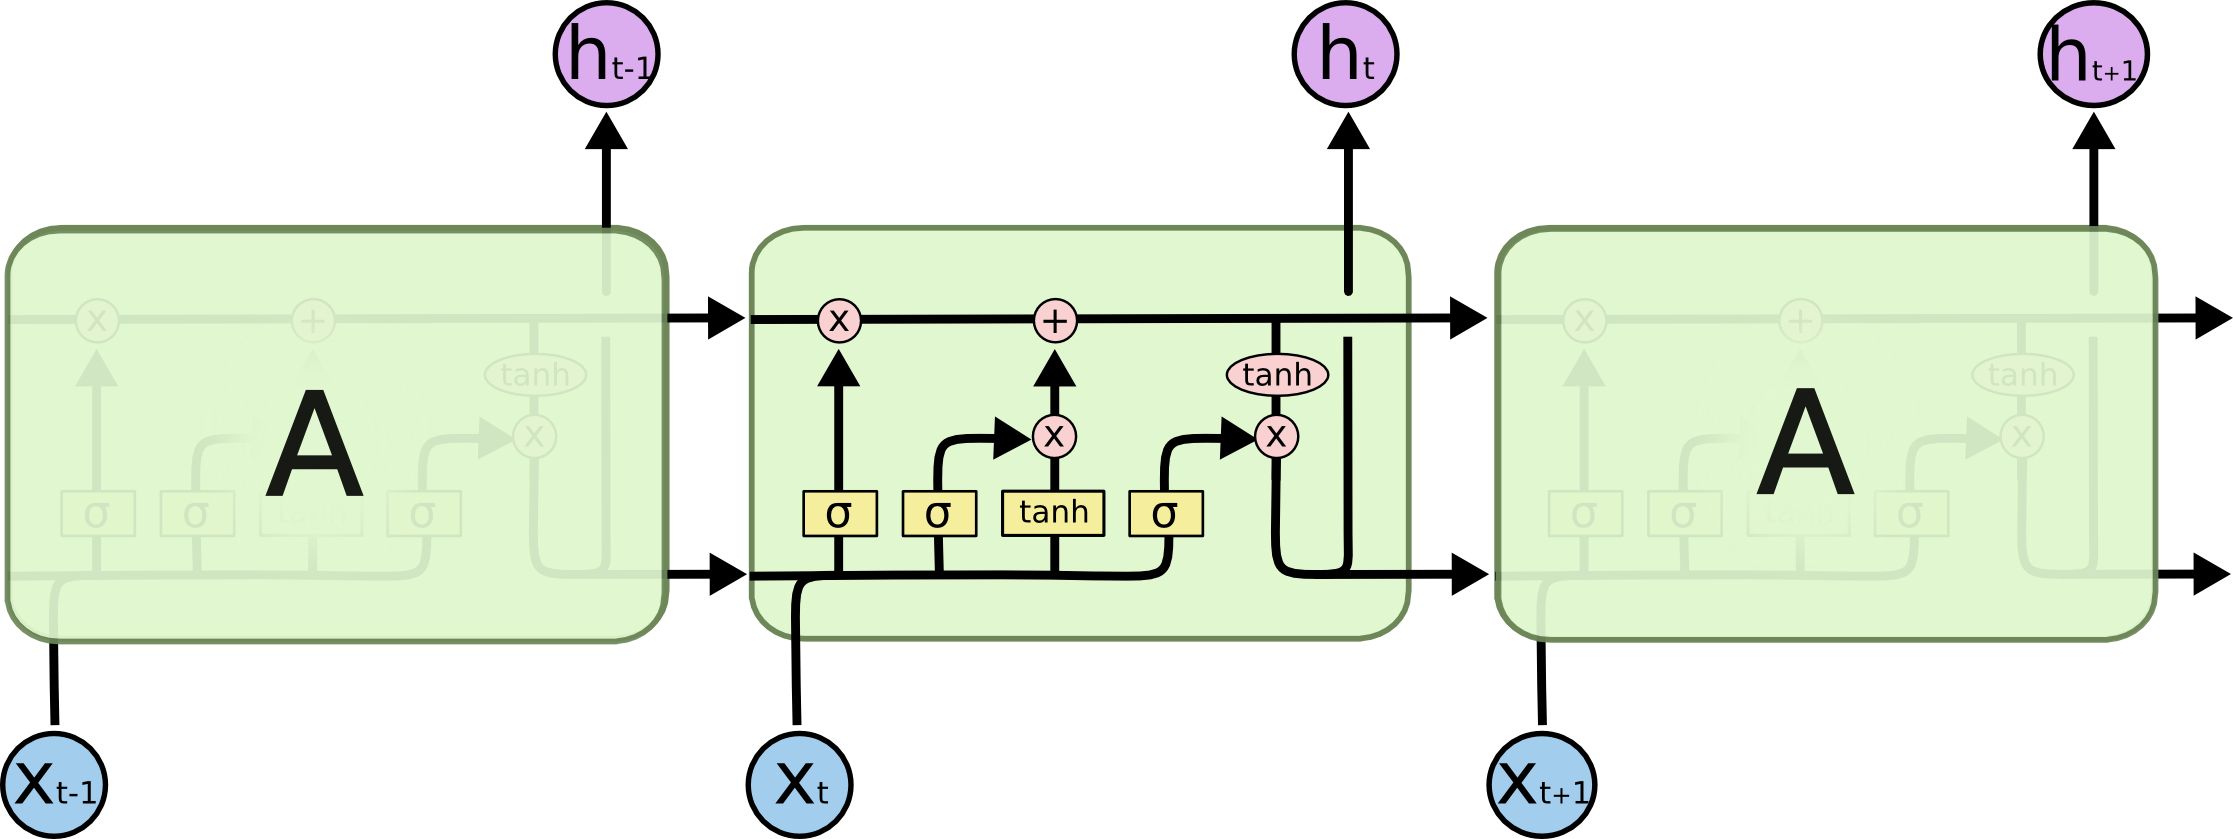

In [12]:
Image(filename='.img/LSTM3-chain.png')

What allows an LSTM to function the way it does is the state vector, that runs across the top of each cell. This allows information to flow through each cell with only minor linear interactions. LSTMs can add or remove information to/from the cell state using sigmoid gates ("`gate`" in the `LSTMCell` class below). For a more comprehensive walkthrough of how LSTMs work, see the following links:


__See also__:
1. http://colah.github.io/posts/2015-08-Understanding-LSTMs/
2. http://karpathy.github.io/2015/05/21/rnn-effectiveness/
3. http://www-dsi.ing.unifi.it/~paolo/ps/tnn-94-gradient.pdf

In [13]:
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state

MAX_RAND_SEED = np.iinfo(np.int32).max
ACTIVATIONS = {
    'sigmoid': tf.sigmoid,
    'relu': tf.nn.relu,
    'elu': tf.nn.elu,
    'tanh': tf.nn.tanh
}

OPTIMIZERS = {
    'sgd': tf.train.GradientDescentOptimizer,
    'adagrad': tf.train.AdagradOptimizer,
    'adam': tf.train.AdamOptimizer
}


def _next_seed(rs):
    return rs.randint(MAX_RAND_SEED)


class LSTMCell(BaseEstimator):
    """Long short term memory (LSTMs) cells attempt to address the 
    problem of "state" in neural networks. The ``LSTMCell`` class
    implements a vanilla LSTM with no peepholes, simply updating the
    state vector in the order: 'f', 'i', 'C', 'o'.
    
    
    Parameters
    ----------
    state_size : int, optional (default=128)
        The size of the state vector, and thus the 
        corresponding weight matrix.
    
    weight_init_lower : float, optional (default=-0.1)
        The lower bound of weight matrix initialization.
    
    weight_init_upper : float, optional (default=0.1)
        The upper bound of weight matrix initialization.
    
    gate : str, optional (default='sigmoid')
        The gating function for persisting information to
        the state vector and between 'f', 'i', and 'o'.
        Default is 'sigmoid' (what most literature uses)
        in order to bound output in 0, 1.
    
    C_gate : str, optional (default='tanh')
        The gating function for the C (state) matrix.
        Default is 'tanh'.
    
    random_state : int or None, optional (default=None)
        The random state used for variable initialization.
        
    
    References
    ----------
    [1] http://colah.github.io/posts/2015-08-Understanding-LSTMs/
    [2] http://karpathy.github.io/2015/05/21/rnn-effectiveness/
    [3] http://www-dsi.ing.unifi.it/~paolo/ps/tnn-94-gradient.pdf
    """
    _stages = ('f', 'i', 'C', 'o')
    
    def __init__(self, state_size=128, weight_init_lower=-0.1, 
                 weight_init_upper=0.1, gate='sigmoid', C_gate='tanh', 
                 random_state=None):
        
        self.state_size = state_size
        self.weight_init_lower = weight_init_lower
        self.weight_init_upper = weight_init_upper
        self.gate = gate
        self.C_gate = C_gate
        self.random_state = random_state
        
        # initialize all the variables
        self._initialize()
    
    def _initialize(self):
        # get a Numpy RandomState object from the seed
        random_state = check_random_state(self.random_state)
        wil, wiu = self.weight_init_lower, self.weight_init_upper
        
        def _w_init():
            # seed random ints that are reproducible
            return tf.Variable(
                tf.random_uniform(
                    [2 * self.state_size, self.state_size], wil, wiu, 
                    seed=_next_seed(random_state)))
        
        # there are four stages in the LSTM:
        # forget, input, C, output. We set the four weight matrices and four bias vectors. 
        # Rather than write eight lines for this with copy/pasted code, here's a hack 
        # that assigns things in a way that's a bit less obvious, but a bit more functional.
        for attr in self._stages:
            setattr(self, "W_%s" % attr, _w_init())
            setattr(self, "b_%s" % attr, tf.Variable(tf.zeros([self.state_size])))
        
    def __call__(self, x_t, h_t1, C_t1):
        X = tf.concat([h_t1, x_t], 1)
        
        # get the gate function, then perform matrix multiplications
        f = ACTIVATIONS[self.gate]
        fc = ACTIVATIONS[self.C_gate]
        
        # The order is f -> i -> C -> o (we are not allowing any peepholes)
        f_t = f(tf.matmul(X, self.W_f) + self.b_f)
        i_t = f(tf.matmul(X, self.W_i) + self.b_i)
        Ctilde_t = fc(tf.matmul(X, self.W_C) + self.b_C)
        o_t = f(tf.matmul(X, self.W_o) + self.b_o)
        
        # It’s now time to update the old cell state, Ct−1, 
        # into the new cell state Ct:
        C_t = f_t * C_t1 + i_t * Ctilde_t
        h_t = o_t * fc(C_t)
        
        # return the hypothesis
        return h_t, C_t

## Seq2Seq

Build a wrapper for a Seq2Seq training sequence:

In [38]:
from sklearn.externals import six
from sklearn.utils.validation import check_is_fitted

def _get_one_example(data, num_steps, random_state):
    offset = random_state.randint(len(data) - num_steps - 1)
    return (
        data[offset:offset + num_steps], 
        data[offset+1:offset+1+num_steps]
    )


def _get_mini_batch(data, batch_size, num_steps, random_state):
    words, targets = zip(*[
        _get_one_example(data, num_steps, random_state)
        for i in range(batch_size)
    ])
    
    return np.array(words), np.array(targets)


class Seq2SeqEstimator(BaseEstimator):
    """Fit a seq2seq inferential estimator. This is a neural network
    with a series (``n_cells``) of ``LSTMCell`` instances to retain
    state. Given an input of a partial sentence, the estimator will 
    generate the inferred next ``n`` words in the sentence.
    
    
    Parameters
    ----------
    vocab_size : int
    
    state_size : int, optional (default=128)
        The size of the LSTM state vectors, and thus 
        the corresponding weight matrices.
    
    embedding_size : int, optional (default=None)
    
    n_cells : int
    
    weight_init_lower : float, optional (default=-0.1)
        The lower bound of weight matrix initialization.
    
    weight_init_upper : float, optional (default=0.1)
        The upper bound of weight matrix initialization.
    
    gate : str, optional (default='sigmoid')
        The gating function for persisting information to
        the state vector and between 'f', 'i', and 'o'.
        Default is 'sigmoid' (what most literature uses)
        in order to bound output in 0, 1.
    
    C_gate : str, optional (default='tanh')
        The gating function for the C (state) matrix.
        Default is 'tanh'.
    
    embedding_init_lower : float, optional (default=-0.2)
        The lower bound for the initialization values of the
        embedding vectors.
    
    embedding_init_upper : float, optional (default=0.2)
        The upper bound for the initialization values of the
        embedding vectors.
    
    batch_size : int, optional (default=32)
        The size of mini batches for training.
    
    num_steps : int, optional (default=16)
        The step size (lag) in the sentences being fit.
    
    clip : float, optional (default=5.0)
        The value at which to clip the gradients.
        
    learning_rate : float, optional (default=1.0)
        The learning rate.
        
    learning_rate_decay : float, optional (default=0.8)
        The rate at which the learning rate decays after
        ``learning_decay_step`` steps.
    
    learning_decay_step : int, optional (default=1000)
        After each ``learning_decay_step`` samples, the learning
        rate will decay by a factor of ``learning_rate_decay``.
    
    optimizer : str, optional (default='sgd')
        The optimizer strategy.
    
    epochs : int, optional (default=100)
        The number of epochs to fit.
        
    unknown_repr : str, optional (default='<unk>')
        The representation of the "unknown" string for words
        that the model has not seen before.
    
    random_state : int or None, optional (default=None)
        The random state used for variable initialization.
        
        
    Attributes
    ----------
    embedding_params_
    
    lstm_
    
    sm_w_
    
    sm_b_
    """
    def __init__(self, state_size=128, embedding_size=None, n_cells=4,
                 weight_init_lower=-0.1, weight_init_upper=0.1, gate='sigmoid', 
                 C_gate='tanh', embedding_init_lower=-0.2, embedding_init_upper=0.2,
                 batch_size=32, num_steps=16, clip=5.0, learning_rate=1.0, 
                 learning_rate_decay=0.8, learning_decay_step=1000, 
                 optimizer='sgd', epochs=100, unknown_repr='<unk>', random_state=None):
        
        # this is actually a hack. it takes all variables from the local
        # namespace and saves them as class attrs. This avoids many lines of,
        # i.e., self.x = x
        for k, v in six.iteritems(locals()):
            setattr(self, k, v)
        
    def clean_session(self):
        """If, i.e., re-fitting a model, this method cleans out the existing tensorflow
        session object, if it exists.
        """
        if hasattr(self, 'sess'):
            self.sess.close()
            delattr(self, 'sess')
        
    def fit(self, sentences):
        # get the vocab from the sentences
        tokens = [s.split() for s in sentences]
        self.vocab_ = set(word for tokenset in tokens for word in tokenset)
        self.vocab_size_ = len(self.vocab_)
        
        # extract the ids from words for classification task
        self.word_to_id_ = dict()
        self.id_to_word_ = dict()
        for i, w in enumerate(self.vocab_):
            self.word_to_id_[w] = i
            self.id_to_word_[i] = w
            
        # make sure there is an unknown class for words we've not seen before
        uktoken = self.unknown_repr
        if uktoken not in self.vocab_:
            self.vocab_.add(uktoken)
            self.vocab_size_ += 1
            self.word_to_id_[uktoken] = i + 1
            self.id_to_word_[i + 1] = uktoken
        
        sentences = [self.word_to_id_[word] for tokenset in tokens for word in tokenset]
        
        # words and targets are placeholders for [batch_size, num_steps]
        # tensor of word and target ids
        self.words_ = words = tf.placeholder(tf.int64, name='words')
        self.targets_ = targets = tf.placeholder(tf.int64, name='targets')
        random_state = check_random_state(self.random_state)
        batch_size = min(len(sentences), self.batch_size)
        num_steps = self.num_steps
        
        # do fit of LSTMs, capture the states and outputs
        _, cost = self._fit(words, targets, random_state, batch_size, num_steps)
        
        # clip gradients
        all_vars = tf.trainable_variables()
        grads = tf.gradients(cost, all_vars)
        grads, _ = tf.clip_by_global_norm(grads, self.clip)
        
        # make a global step variable but mark it not trainable
        global_step = tf.Variable(0, trainable=False)
        
        # Decay the learning rate by 0.8 every 1000 steps
        learning_rate = self.learning_rate
        learning_rate = tf.train.exponential_decay(
            learning_rate, global_step, 
            self.learning_decay_step, 
            self.learning_rate_decay)
        
        # get the optimizer
        optimizer = OPTIMIZERS[self.optimizer](learning_rate)
        
        # apply_gradients increments the global_step
        train_op = optimizer.apply_gradients(
            zip(grads, all_vars), global_step=global_step)
        
        # initialize global vars for tf - replace them if they already exist
        init = tf.global_variables_initializer()
        self.clean_session()
        sess = self.sess = tf.InteractiveSession()

        # run the training session
        sess.run(init)
        
        # now fit batches
        self.costs_ = []
        for step_number in range(self.epochs):
            w, t = _get_mini_batch(sentences, batch_size, num_steps, random_state)
            c, _ = sess.run([cost, train_op], feed_dict={words: w, targets: t})
            self.costs_.append(c)
            
            if step_number % 10 == 0:
                print('Epoch %d cost: %.3f' % (step_number, c))
                
        # Here we set up our decision function for later generating predictions
        (self._pred, self._output, self._state,
         self._output_in, self._state_in) = self._decision_function()
        
        return self
    
    def _decision_function(self):
        # what we are doing here is setting up the prediction function for later.
        # since we have our placeholders, this is just chaining lazily-evaluated
        # functions that will be evaluated at predict time.
        ns = self.num_steps
        embedding = tf.nn.embedding_lookup(self.embedding_params_, self.words_[:0])
        output_in = [tf.zeros([1, self.state_size])] * ns
        state_in = [tf.zeros([1, self.state_size])] * ns
        output = [0.] * ns
        state = [0.] * ns
        
        # Run the LSTM cells
        output[0], state[0] = self.lstm_[0](embedding, output_in[0], state_in[0])
        for d in range(1, len(self.lstm_)):
            output[d], state[d] = self.lstm_[d](output[d-1], output_in[d], state_in[d])
        
        # Get the logits
        logits = tf.matmul(output[-1], self.sm_w_) + self.sm_b_
        
        # Get the softmax predictions
        preds = tf.nn.softmax(logits)
        
        return preds, output, state, output_in, state_in
        
    def _fit(self, words, targets, random_state, batch_size, num_steps):
        # validation of some vars
        embedding_size = self.embedding_size
        state_size = self.state_size
        if embedding_size is None:
            embedding_size = state_size
            
        # get the embedding params
        vocab_size = self.vocab_size_
        self.embedding_params_ = tf.Variable(
            tf.random_uniform([vocab_size, embedding_size], 
                              self.embedding_init_lower, 
                              self.embedding_init_upper,
                              seed=_next_seed(random_state)))
        
        # initialize the lstm cells
        wil, wiu = self.weight_init_lower, self.weight_init_upper
        self.lstm_ = [
            LSTMCell(state_size=state_size, weight_init_lower=wil,
                     weight_init_upper=wiu, gate=self.gate,
                     C_gate=self.C_gate, random_state=random_state)
            for _ in range(self.n_cells)
        ]
        
        self.sm_w_ = tf.Variable(
            tf.random_uniform(
                [embedding_size, vocab_size], 
                wil, wiu, seed=_next_seed(random_state)))
        
        self.sm_b_ = tf.Variable(tf.zeros([vocab_size]))
        
        preds = []
        cost = 0.0
        
        # track the output, states
        output = [tf.zeros([batch_size, state_size])] * num_steps
        state = [tf.zeros([batch_size, state_size])] * num_steps
        
        for i in range(num_steps):
            # Get the embedding for words
            embedding = tf.nn.embedding_lookup(self.embedding_params_, words[:, i])
            
            # get the output of the first LSTM
            output[0], state[0] = self.lstm_[0](embedding, output[0], state[0])
            for d in range(1, len(self.lstm_)):
                output[d], state[d] = self.lstm_[d](output[d-1], output[d], state[d])
                
            # Get the logits, predictions
            logits = tf.matmul(output[-1], self.sm_w_) + self.sm_b_
            
            # Get the softmax predictions
            preds.append(tf.nn.softmax(logits))
            
            # Cost per step
            cost += tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=logits, labels=targets[:, i]))
            
        # Average cost across time steps
        cost = cost / np.float32(num_steps)
        return preds, cost
    
    def predict(self, partial_sentences, next_k=1):
        check_is_fitted(self, 'lstm_')
        
        # make sure it's a list or iterable
        wasstr = False
        if isinstance(partial_sentences, six.string_types):
            partial_sentences = [partial_sentences]
            wasstr = True
        if not hasattr(partial_sentences, '__iter__'):
            raise ValueError('Expected iterable')
        
        results = [self._predict_one(sent, next_k) for sent in partial_sentences]
        
        # if it came in as a string, just return a string
        if wasstr:
            return results[0]
        return results
        
    def _predict_one(self, partial_sentence, next_k):
        # get the session graph
        sess = self.sess
        
        # map words to IDs
        word_map = self.word_to_id_
        uk_id = word_map[self.unknown_repr]
        start_words = partial_sentence.split()
        
        # get the decision function and stored states
        output, state = self._output, self._state
        output_in, state_in = self._output_in, self._state_in
        pred = self._pred
        
        # get the placeholders for words and targets
        w = np.array([[word_map.get(start_words[0], uk_id)]])
        t = sess.run([pred], feed_dict={self.words_: w})
        
        sentence = [start_words[0]]
        for i in range(len(start_words) + next_k):
            if i + 1 < len(start_words):
                w[0, 0] = word_map.get(start_words[i+1], uk_id)
            else:
                w[0, 0] = min(self.vocab_size_, np.sum(np.cumsum(t[0]) < np.random.rand()))
                
            sentence.append(self.id_to_word_[w[0, 0]])
            feed_dict = dict([(output_in[i], t[1+i]) for i in range(self.num_steps)]+
                             [(state_in[i], t[5+i]) for i in range(self.num_steps)] +
                             [(self.words_, w)])
            
            t = sess.run([pred], feed_dict=feed_dict)
            
        return ' '.join(sentence)

In [39]:
# this is obviously made up, and a toy set
sentences = ('this is just a sentence', 
             'this is an example sentence', 
             'and here is another example sentence', 
             'this is a cat')

In [40]:
clf = Seq2SeqEstimator()
clf.fit(sentences)

Epoch 0 cost: 2.485
Epoch 10 cost: 2.277
Epoch 20 cost: 2.239
Epoch 30 cost: 2.220
Epoch 40 cost: 2.207
Epoch 50 cost: 2.210
Epoch 60 cost: 2.199
Epoch 70 cost: 2.201
Epoch 80 cost: 2.201
Epoch 90 cost: 2.204


ValueError: Shape must be rank 2 but is rank 0 for 'MatMul_1685' (op: 'MatMul') with input shapes: [], [128,12].

In [34]:
clf.predict("this is a")

IndexError: list index out of range

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(x=range(len(clf.costs_)), y=clf.costs_)
plt.show()